In [95]:
import episcanpy.api as epi
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns

# Load data

In [41]:
scdata1 = sc.read_10x_h5('../../pbmc-joint/ngs.sanger.ac.uk/scratch/project/team205/pbmc-joint/PBMCdual9478966-PBMCdual9466975/outs/filtered_feature_bc_matrix.h5', gex_only=False)
scdata1.var_names_make_unique()
scdata1

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 3567 × 103293 
    var: 'gene_ids', 'feature_types', 'genome'

In [175]:
scrna1 = scdata1[:, scdata1.var['feature_types'] == 'Gene Expression']
scatac1 = scdata1[:, scdata1.var['feature_types'] == 'Peaks']
scrna1, scatac1

(View of AnnData object with n_obs × n_vars = 3567 × 36601 
     var: 'gene_ids', 'feature_types', 'genome',
 View of AnnData object with n_obs × n_vars = 3567 × 66692 
     var: 'gene_ids', 'feature_types', 'genome')

In [44]:
scdata2 = sc.read_10x_h5('../../pbmc-joint/ngs.sanger.ac.uk/scratch/project/team205/pbmc-joint/PBMCdual9478967-PBMCdual9466976/outs/filtered_feature_bc_matrix.h5', gex_only=False)
scdata2.var_names_make_unique()
scdata2

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 4388 × 102814 
    var: 'gene_ids', 'feature_types', 'genome'

In [45]:
scrna2 = scdata2[:, scdata2.var['feature_types'] == 'Gene Expression']
scatac2 = scdata2[:, scdata2.var['feature_types'] == 'Peaks']
scrna2, scatac2

(View of AnnData object with n_obs × n_vars = 4388 × 36601 
     var: 'gene_ids', 'feature_types', 'genome',
 View of AnnData object with n_obs × n_vars = 4388 × 66213 
     var: 'gene_ids', 'feature_types', 'genome')

# First batch

## Preprocess RNA-seq

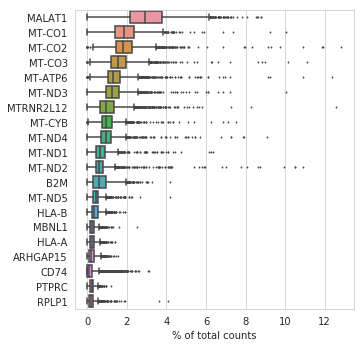

In [187]:
sc.pl.highest_expr_genes(scrna1, n_top=20)

In [188]:
sc.pp.filter_cells(scrna1, min_genes=100)
sc.pp.filter_genes(scrna1, min_cells=3)
scrna1

Trying to set attribute `.obs` of view, making a copy.


AnnData object with n_obs × n_vars = 3518 × 22955 
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [189]:
scrna1.var['mt'] = scrna1.var.index.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(scrna1, qc_vars=['mt'], percent_top=None, inplace=True)
scrna1

AnnData object with n_obs × n_vars = 3518 × 22955 
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

... storing 'feature_types' as categorical
... storing 'genome' as categorical


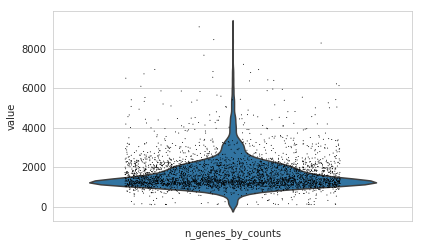

In [190]:
sc.pl.violin(scrna1, 'n_genes_by_counts', jitter=0.3)

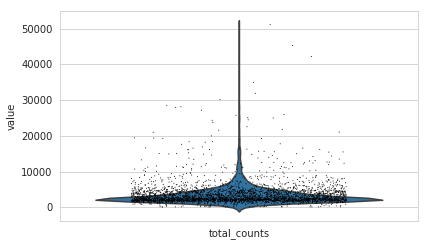

In [191]:
sc.pl.violin(scrna1, 'total_counts', jitter=0.3)

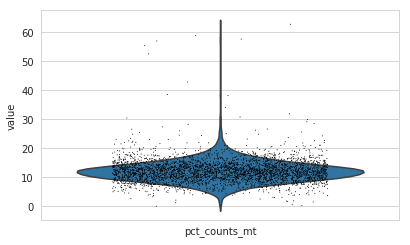

In [192]:
sc.pl.violin(scrna1, 'pct_counts_mt', jitter=0.3)

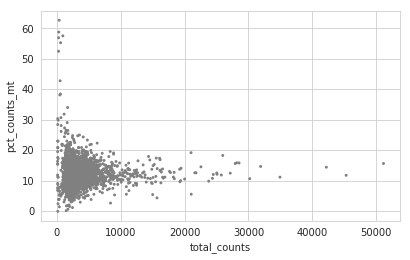

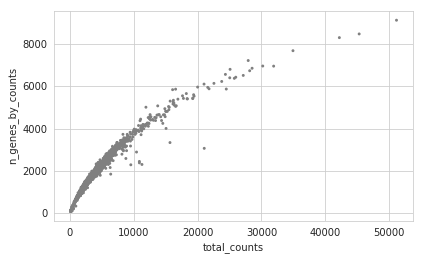

In [193]:
sc.pl.scatter(scrna1, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(scrna1, x='total_counts', y='n_genes_by_counts')

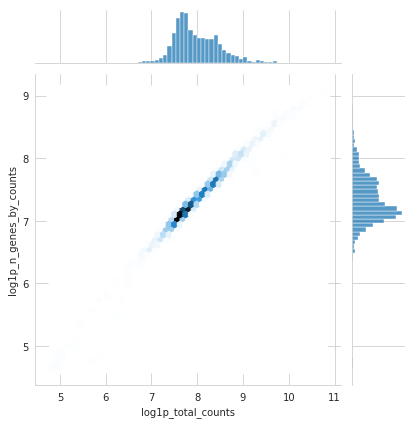

In [194]:
sns.jointplot("log1p_total_counts", "log1p_n_genes_by_counts", data=scrna1.obs, kind='hex')

In [195]:
scrna1 = scrna1[scrna1.obs.n_genes_by_counts < 6000, :]
scrna1 = scrna1[scrna1.obs.pct_counts_mt < 25, :]
scrna1

View of AnnData object with n_obs × n_vars = 3475 × 22955 
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [196]:
rna_meta = pd.read_csv('../data/new-data-2020/PBMC_RNA_Meta.csv', index_col=0)
rna_meta.head()

,Cell type
Cell,
ds1_AAACAGCCATTGTGCA-1,cDC
ds1_AAACATGCAAGACTCC-1,NK
ds1_AAACATGCAATATACC-1,CD14 IL1B Monocyte
ds1_AAACCGAAGCCTGGTA-1,CD16 Monocyte
ds1_AAACCGAAGGAGGTTA-1,CD4 Naive


In [197]:
rna_meta = rna_meta.rename(columns={"Cell type": "cell_type"})

In [198]:
rna_meta1 = rna_meta[rna_meta.index.str.startswith('ds1_')]
rna_meta1.index = [name[4:]for name in rna_meta1.index]
rna_meta1.head()

,cell_type
AAACAGCCATTGTGCA-1,cDC
AAACATGCAAGACTCC-1,NK
AAACATGCAATATACC-1,CD14 IL1B Monocyte
AAACCGAAGCCTGGTA-1,CD16 Monocyte
AAACCGAAGGAGGTTA-1,CD4 Naive


In [199]:
scrna1.obs = scrna1.obs.join(rna_meta1)
scrna1.obs

,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,cell_type
AAACAGCCATTGTGCA-1,2283,2278,7.731492,5325.0,8.580356,889.0,6.791222,16.694836,cDC
AAACATGCAAGACTCC-1,1636,1634,7.399398,2788.0,7.933438,238.0,5.476463,8.536586,NK
AAACATGCAATATACC-1,1556,1553,7.348588,3037.0,8.018954,363.0,5.897154,11.952585,CD14 IL1B Monocyte
AAACCGAAGCCTGGTA-1,2047,2046,7.624131,4592.0,8.432289,674.0,6.514713,14.677700,CD16 Monocyte
AAACCGAAGGAGGTTA-1,1442,1442,7.274480,2561.0,7.848544,266.0,5.587249,10.386567,CD4 Naive
...,...,...,...,...,...,...,...,...,...
TTTGTCCCATTATGAC-1,1180,1180,7.074117,2056.0,7.629004,266.0,5.587249,12.937742,MAIT
TTTGTGAAGTTTGGTA-1,1158,1156,7.053586,1890.0,7.544861,182.0,5.209486,9.629629,CD8 Naive
TTTGTGGCATGCTATG-1,1263,1262,7.141245,2249.0,7.718686,272.0,5.609472,12.094264,Bcell Naive
TTTGTGTTCACATTGA-1,1238,1238,7.122060,2123.0,7.661057,183.0,5.214936,8.619878,CD8 Naive


In [200]:
scrna1 = scrna1[~scrna1.obs['cell_type'].isnull()]

In [201]:
scrna1

View of AnnData object with n_obs × n_vars = 2863 × 22955 
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [202]:
scrna1.raw = scrna1

In [203]:
sc.pp.normalize_total(scrna1, target_sum=1e4)
sc.pp.log1p(scrna1)

In [204]:
sc.tl.pca(scrna1, random_state=0, svd_solver='arpack', n_comps=50)

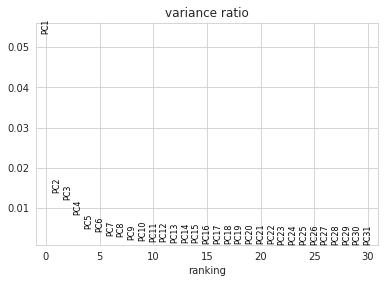

In [205]:
sc.pl.pca_variance_ratio(scrna1)

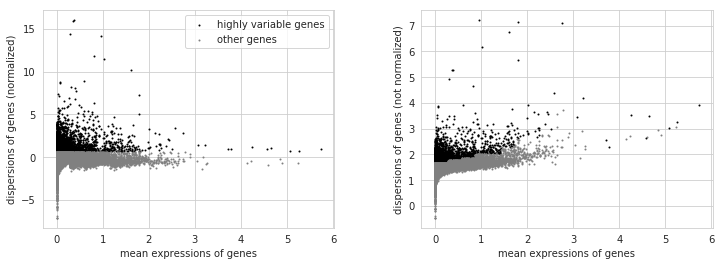

number of highly variable genes = 4000


In [206]:
sc.pp.highly_variable_genes(scrna1, n_top_genes=4000)
sc.pl.highly_variable_genes(scrna1)
print('number of highly variable genes =', scrna1.var.highly_variable.sum())

In [207]:
scrna_hvg1 = scrna1[:, scrna1.var.highly_variable]
scrna_hvg1

View of AnnData object with n_obs × n_vars = 2863 × 4000 
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [208]:
scrna1.layers['count'] = scrna1.raw.X
scrna1.raw = None

In [209]:
scrna_hvg1.layers['count'] = scrna_hvg1.raw[:, scrna1.var.highly_variable].X
scrna_hvg1.raw = None

## Preprocess ATAC

In [176]:
epi.pp.filter_features(scatac1, min_cells=1)
epi.pp.filter_cells(scatac1, min_features=1)
scatac1

Trying to set attribute `.var` of view, making a copy.


AnnData object with n_obs × n_vars = 3567 × 66504 
    obs: 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [177]:
epi.pp.binarize(scatac1)
scatac1

AnnData object with n_obs × n_vars = 3567 × 66504 
    obs: 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

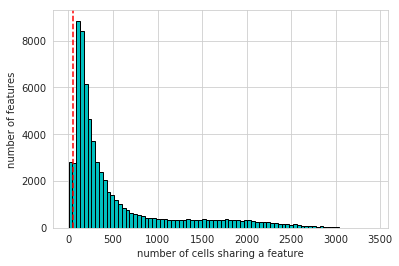

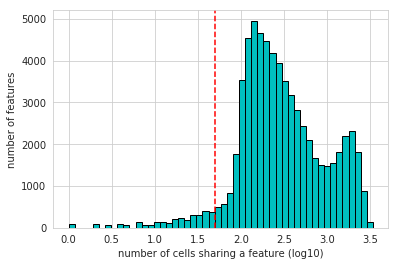

In [178]:
epi.pp.coverage_features(scatac1, binary=True, log=False, bins=50, threshold=50)
epi.pp.coverage_features(scatac1, binary=True, log=10, bins=50, threshold=50)

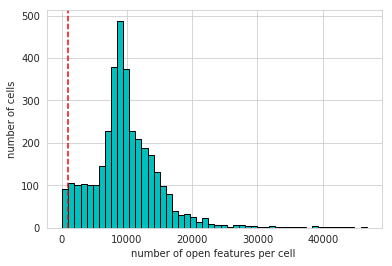

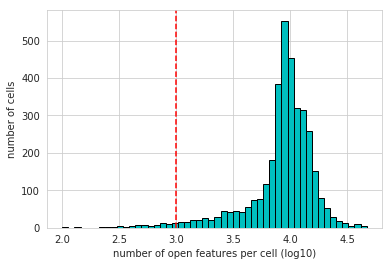

In [179]:
epi.pp.coverage_cells(scatac1, binary=True, log=False, bins=50, threshold=1000)
epi.pp.coverage_cells(scatac1, binary=True, log=10, bins=50, threshold=1000)

In [180]:
epi.pp.filter_cells(scatac1, min_features=1000)
epi.pp.filter_features(scatac1, min_cells=50)
scatac1

AnnData object with n_obs × n_vars = 3479 × 63377 
    obs: 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness'

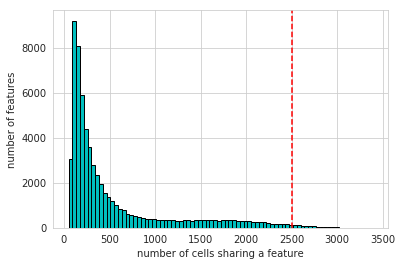

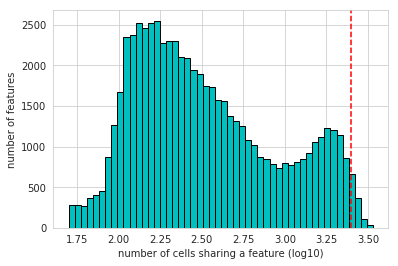

In [181]:
epi.pp.coverage_features(scatac1, binary=True, log=False, bins=50, threshold=2500)
epi.pp.coverage_features(scatac1, binary=True, log=True, bins=50, threshold=2500)

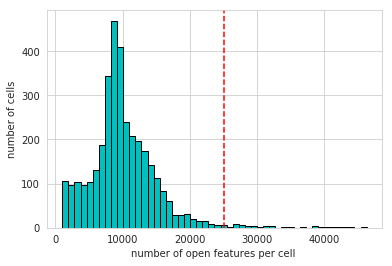

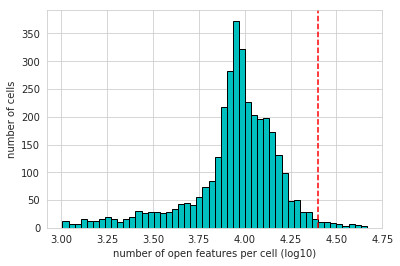

In [182]:
epi.pp.coverage_cells(scatac1, binary=True, log=False, bins=50, threshold=25000)
epi.pp.coverage_cells(scatac1, binary=True, log=True, bins=50, threshold=25000)

In [183]:
epi.pp.filter_cells(scatac1, max_features=25000)
epi.pp.filter_features(scatac1, max_cells=2500)
scatac1

AnnData object with n_obs × n_vars = 3425 × 62657 
    obs: 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness'

In [184]:
scatac1.layers['binary'] = scatac1.X
epi.pp.normalize_total(scatac1, target_sum=1e4)
epi.pp.log1p(scatac1)

In [213]:
com_index = scrna1.obs.index.intersection(scatac1.obs.index)
scrna1 = scrna1[com_index]
scatac1 = scatac1[com_index]
print(scrna1.shape, scatac1.shape)

(2859, 22955) (2859, 62657)


In [217]:
scatac1.obs = scatac1.obs.join(scrna1.obs[['cell_type']])
scatac1

AnnData object with n_obs × n_vars = 2859 × 62657 
    obs: 'nb_features', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness'
    layers: 'binary'

In [218]:
scrna1.write('../data/new-data-2020/expressions.h5ad')
scatac1.write('../data/new-data-2020/peaks.h5ad')

Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_type' as categorical
... storing 'cell_type' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


## Filter

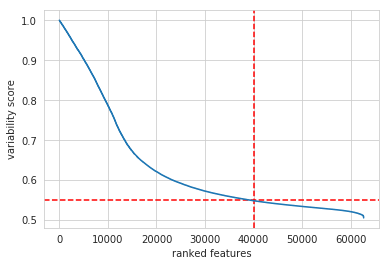

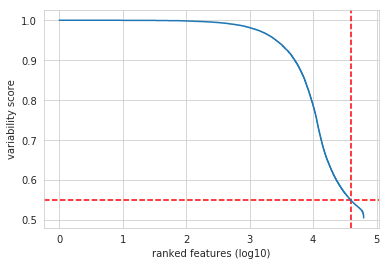

In [219]:
min_score_value = 0.55
nb_feature_selected = 40000
epi.pl.variability_features(scatac1, log=None, min_score=min_score_value, nb_features=nb_feature_selected)
epi.pl.variability_features(scatac1, log='log10', min_score=min_score_value, nb_features=nb_feature_selected)

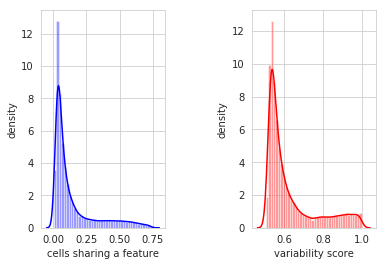

In [220]:
epi.pp.select_var_feature(scatac1, nb_features=nb_feature_selected)

In [223]:
epi.pp.normalize_total(scatac1, target_sum=1e4)
epi.pp.log1p(scatac1)

In [228]:
com_index = scrna_hvg1.obs.index.intersection(scatac1.obs.index)
scrna_hvg1 = scrna_hvg1[com_index]
scatac1 = scatac1[com_index]
print(scrna_hvg1.shape, scatac1.shape)

(2859, 4000) (2859, 40099)


In [231]:
scrna_hvg1.write('../data/new-data-2020/expressions_hvg.h5ad')
scatac1.write('../data/new-data-2020/peaks_hvf.h5ad')

Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_type' as categorical


# Second batch

In [232]:
scdata2 = sc.read_10x_h5('../../pbmc-joint/ngs.sanger.ac.uk/scratch/project/team205/pbmc-joint/PBMCdual9478967-PBMCdual9466976/outs/filtered_feature_bc_matrix.h5', gex_only=False)
scdata2.var_names_make_unique()
scdata2

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 4388 × 102814 
    var: 'gene_ids', 'feature_types', 'genome'

In [233]:
scrna2 = scdata2[:, scdata2.var['feature_types'] == 'Gene Expression']
scatac2 = scdata2[:, scdata2.var['feature_types'] == 'Peaks']
scrna2, scatac2

(View of AnnData object with n_obs × n_vars = 4388 × 36601 
     var: 'gene_ids', 'feature_types', 'genome',
 View of AnnData object with n_obs × n_vars = 4388 × 66213 
     var: 'gene_ids', 'feature_types', 'genome')

## Preprocess RNA-seq

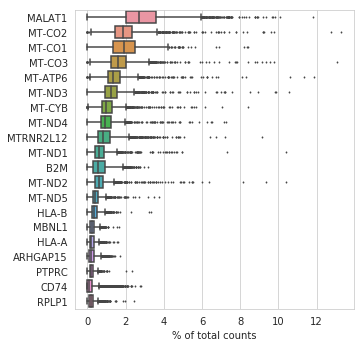

In [234]:
sc.pl.highest_expr_genes(scrna2, n_top=20)

In [235]:
sc.pp.filter_cells(scrna2, min_genes=100)
sc.pp.filter_genes(scrna2, min_cells=3)
scrna2

Trying to set attribute `.obs` of view, making a copy.


AnnData object with n_obs × n_vars = 4354 × 23305 
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [236]:
scrna2.var['mt'] = scrna2.var.index.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(scrna2, qc_vars=['mt'], percent_top=None, inplace=True)
scrna2

AnnData object with n_obs × n_vars = 4354 × 23305 
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

... storing 'feature_types' as categorical
... storing 'genome' as categorical


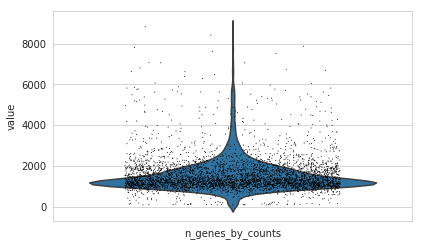

In [237]:
sc.pl.violin(scrna2, 'n_genes_by_counts', jitter=0.3)

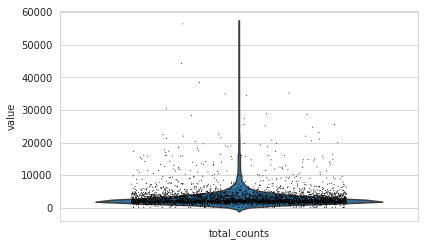

In [238]:
sc.pl.violin(scrna2, 'total_counts', jitter=0.3)

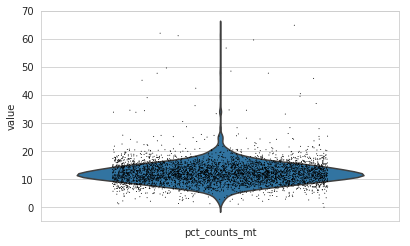

In [239]:
sc.pl.violin(scrna2, 'pct_counts_mt', jitter=0.3)

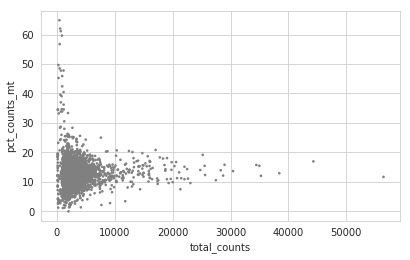

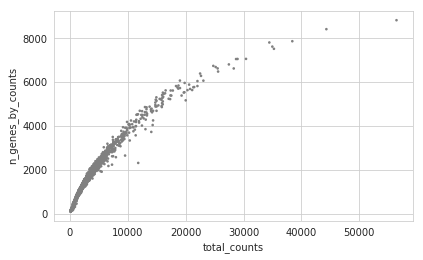

In [240]:
sc.pl.scatter(scrna2, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(scrna2, x='total_counts', y='n_genes_by_counts')

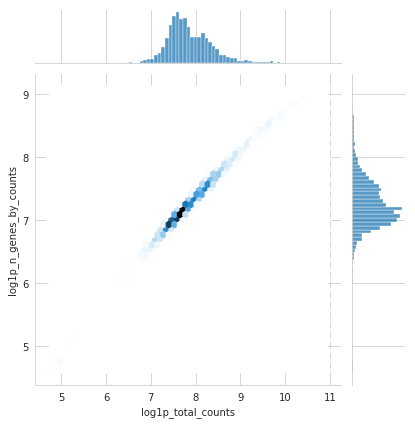

In [241]:
sns.jointplot("log1p_total_counts", "log1p_n_genes_by_counts", data=scrna2.obs, kind='hex')

In [242]:
scrna2 = scrna2[scrna2.obs.n_genes_by_counts < 6000, :]
scrna2 = scrna2[scrna2.obs.pct_counts_mt < 25, :]
scrna2

View of AnnData object with n_obs × n_vars = 4291 × 23305 
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [243]:
rna_meta = pd.read_csv('../data/new-data-2020/PBMC_RNA_Meta.csv', index_col=0)
rna_meta.head()

,Cell type
Cell,
ds1_AAACAGCCATTGTGCA-1,cDC
ds1_AAACATGCAAGACTCC-1,NK
ds1_AAACATGCAATATACC-1,CD14 IL1B Monocyte
ds1_AAACCGAAGCCTGGTA-1,CD16 Monocyte
ds1_AAACCGAAGGAGGTTA-1,CD4 Naive


In [244]:
rna_meta = rna_meta.rename(columns={"Cell type": "cell_type"})

In [245]:
rna_meta2 = rna_meta[rna_meta.index.str.startswith('ds2_')]
rna_meta2.index = [name[4:]for name in rna_meta2.index]
rna_meta2.head()

,cell_type
AAACAGCCAGCTTACA-1,CD14 IL1B Monocyte
AAACATGCACATGCTA-1,Cycling
AAACATGCAGAATGAC-1,CD8 Naive
AAACCAACAGCGCTTG-1,NK
AAACCGAAGCCATCAG-1,CD4 Naive


In [246]:
scrna2.obs = scrna2.obs.join(rna_meta2)
scrna2.obs

,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,cell_type
AAACAGCCAGCTTACA-1,1662,1660,7.415175,3286.0,8.097731,446.0,6.102559,13.572733,CD14 IL1B Monocyte
AAACATGCACATGCTA-1,2779,2777,7.929487,6070.0,8.711279,919.0,6.824374,15.140033,Cycling
AAACATGCAGAATGAC-1,1148,1148,7.046647,2113.0,7.656337,368.0,5.910797,17.415997,CD8 Naive
AAACCAACAGCGCTTG-1,872,872,6.771936,1362.0,7.217443,216.0,5.379897,15.859030,NK
AAACCGAAGCAGGTTT-1,4338,4331,8.373785,12219.0,9.410830,993.0,6.901737,8.126688,NaN
...,...,...,...,...,...,...,...,...,...
TTTGTGTTCTCAATTC-1,1946,1946,7.574045,3971.0,8.287025,506.0,6.228511,12.742382,CD14 IL1B Monocyte
TTTGTGTTCTCGACCT-1,1373,1372,7.224753,2272.0,7.728856,63.0,4.158883,2.772887,CD14 IL1B Monocyte
TTTGTTGGTAATCGCA-1,3268,3267,8.091933,7978.0,8.984569,949.0,6.856462,11.895212,Cycling
TTTGTTGGTCATCCTG-1,1655,1655,7.412160,3152.0,8.056109,315.0,5.755742,9.993654,CD14 IL1B Monocyte


In [247]:
scrna2 = scrna2[~scrna2.obs['cell_type'].isnull()]
scrna2

View of AnnData object with n_obs × n_vars = 3479 × 23305 
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [248]:
scrna2.raw = scrna2

In [249]:
sc.pp.normalize_total(scrna2, target_sum=1e4)
sc.pp.log1p(scrna2)

In [250]:
sc.tl.pca(scrna2, random_state=0, svd_solver='arpack', n_comps=50)

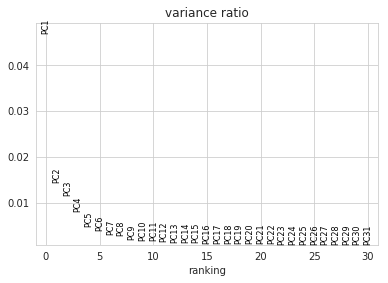

In [251]:
sc.pl.pca_variance_ratio(scrna2)

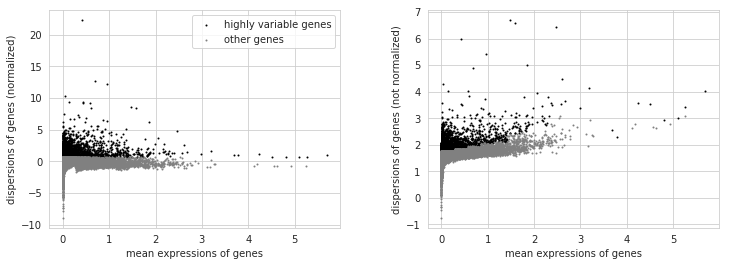

number of highly variable genes = 4000


In [252]:
sc.pp.highly_variable_genes(scrna2, n_top_genes=4000)
sc.pl.highly_variable_genes(scrna2)
print('number of highly variable genes =', scrna1.var.highly_variable.sum())

In [253]:
scrna_hvg2 = scrna2[:, scrna2.var.highly_variable]
scrna_hvg2

View of AnnData object with n_obs × n_vars = 3479 × 4000 
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [254]:
scrna2.layers['count'] = scrna2.raw.X
scrna2.raw = None

In [255]:
scrna_hvg2.layers['count'] = scrna_hvg2.raw[:, scrna2.var.highly_variable].X
scrna_hvg2.raw = None

## Preprocess ATAC

In [256]:
epi.pp.filter_features(scatac2, min_cells=1)
epi.pp.filter_cells(scatac2, min_features=1)
scatac2

Trying to set attribute `.var` of view, making a copy.


AnnData object with n_obs × n_vars = 4388 × 66033 
    obs: 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

In [257]:
epi.pp.binarize(scatac2)
scatac2

AnnData object with n_obs × n_vars = 4388 × 66033 
    obs: 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

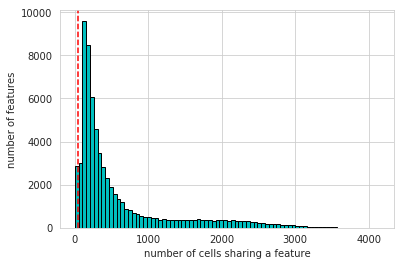

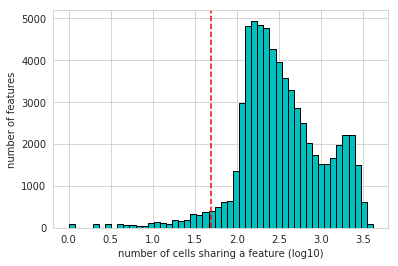

In [258]:
epi.pp.coverage_features(scatac2, binary=True, log=False, bins=50, threshold=50)
epi.pp.coverage_features(scatac2, binary=True, log=10, bins=50, threshold=50)

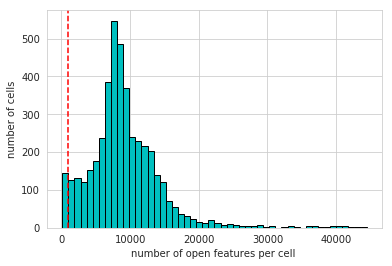

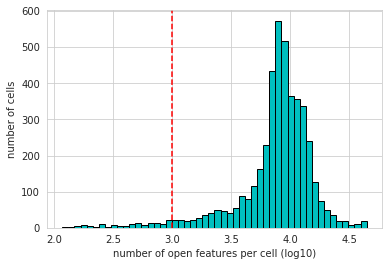

In [259]:
epi.pp.coverage_cells(scatac2, binary=True, log=False, bins=50, threshold=1000)
epi.pp.coverage_cells(scatac2, binary=True, log=10, bins=50, threshold=1000)

In [260]:
epi.pp.filter_cells(scatac2, min_features=1000)
epi.pp.filter_features(scatac2, min_cells=50)
scatac2

AnnData object with n_obs × n_vars = 4243 × 63312 
    obs: 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness'

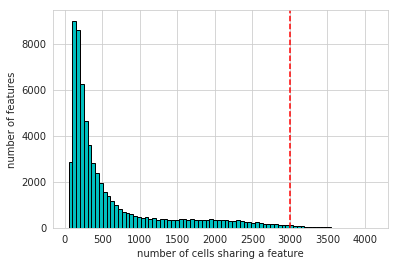

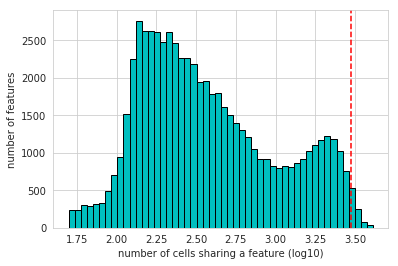

In [262]:
epi.pp.coverage_features(scatac2, binary=True, log=False, bins=50, threshold=3000)
epi.pp.coverage_features(scatac2, binary=True, log=True, bins=50, threshold=3000)

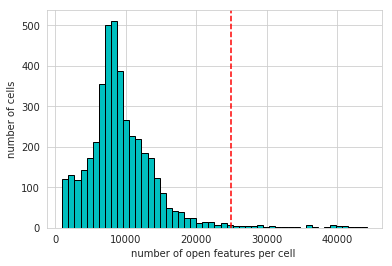

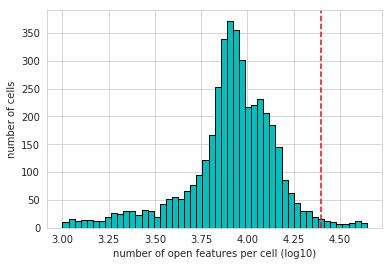

In [263]:
epi.pp.coverage_cells(scatac2, binary=True, log=False, bins=50, threshold=25000)
epi.pp.coverage_cells(scatac2, binary=True, log=True, bins=50, threshold=25000)

In [264]:
epi.pp.filter_cells(scatac2, max_features=25000)
epi.pp.filter_features(scatac2, max_cells=3000)
scatac2

AnnData object with n_obs × n_vars = 4170 × 62834 
    obs: 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness'

In [265]:
scatac2.layers['binary'] = scatac2.X
epi.pp.normalize_total(scatac2, target_sum=1e4)
epi.pp.log1p(scatac2)

In [266]:
com_index = scrna2.obs.index.intersection(scatac2.obs.index)
scrna2 = scrna2[com_index]
scatac2 = scatac2[com_index]
print(scrna2.shape, scatac2.shape)

(3475, 23305) (3475, 62834)


In [267]:
scatac2.obs = scatac2.obs.join(scrna2.obs[['cell_type']])
scatac2

AnnData object with n_obs × n_vars = 3475 × 62834 
    obs: 'nb_features', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness'
    layers: 'binary'

In [268]:
scrna2.write('../data/new-data-2020/expressions-2.h5ad')
scatac2.write('../data/new-data-2020/peaks-2.h5ad')

Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_type' as categorical
... storing 'cell_type' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


## Filter

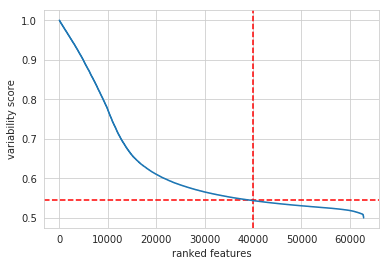

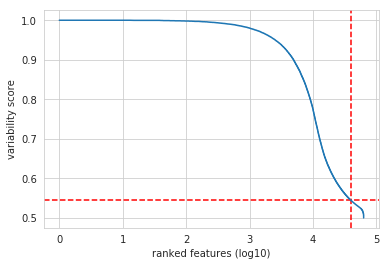

In [271]:
min_score_value = 0.545
nb_feature_selected = 40000
epi.pl.variability_features(scatac2, log=None, min_score=min_score_value, nb_features=nb_feature_selected)
epi.pl.variability_features(scatac2, log='log10', min_score=min_score_value, nb_features=nb_feature_selected)

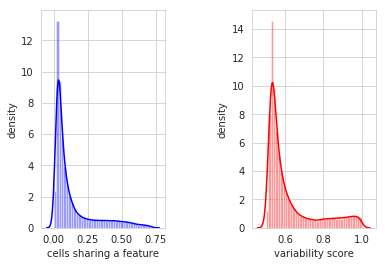

In [272]:
epi.pp.select_var_feature(scatac2, nb_features=nb_feature_selected)

In [273]:
epi.pp.normalize_total(scatac2, target_sum=1e4)
epi.pp.log1p(scatac2)

In [274]:
com_index = scrna_hvg2.obs.index.intersection(scatac2.obs.index)
scrna_hvg2 = scrna_hvg2[com_index]
scatac2 = scatac2[com_index]
print(scrna_hvg2.shape, scatac2.shape)

(3475, 4000) (3475, 40122)


In [275]:
scrna_hvg2.write('../data/new-data-2020/expressions_hvg-2.h5ad')
scatac2.write('../data/new-data-2020/peaks_hvf-2.h5ad')

Trying to set attribute `.obs` of view, making a copy.
... storing 'cell_type' as categorical


# Visualization

## RNA-seq

In [286]:
sc.pp.neighbors(scrna_hvg1)
sc.tl.umap(scrna_hvg1)

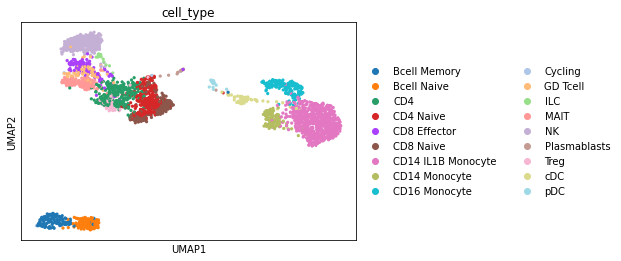

In [287]:
sc.pl.umap(scrna_hvg1, color='cell_type')

In [288]:
sc.pp.neighbors(scrna_hvg2)
sc.tl.umap(scrna_hvg2)

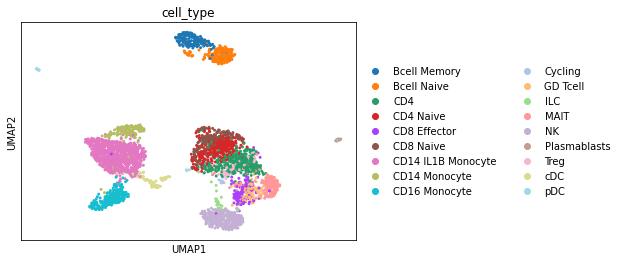

In [289]:
sc.pl.umap(scrna_hvg2, color='cell_type')

### Both batches

In [295]:
scrna1=sc.read('../data/new-data-2020/expressions.h5ad')
scrna1

AnnData object with n_obs × n_vars = 2859 × 22955
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'count'

In [296]:
scrna2 = sc.read('../data/new-data-2020/expressions-2.h5ad')
scrna2

AnnData object with n_obs × n_vars = 3475 × 23305
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'count'

In [297]:
rna = scrna1.concatenate(scrna2)
rna

AnnData object with n_obs × n_vars = 6334 × 21819
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'cell_type', 'batch'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'log1p_mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'log1p_total_counts-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'log1p_mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'log1p_total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'
    obsm: 'X_pca'
    layers: 'count'

/home/icb/anastasia.litinetskaya/miniconda3/envs/mofa/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


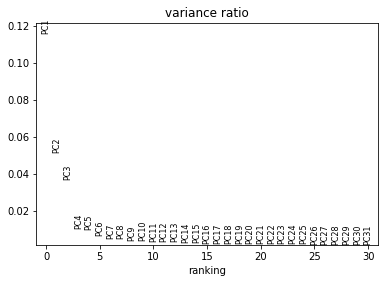

In [299]:
sc.pp.highly_variable_genes(rna, n_top_genes=4000)
sc.tl.pca(rna, random_state=0, svd_solver='arpack', n_comps=50)
sc.pl.pca_variance_ratio(rna)

In [300]:
sc.pp.neighbors(rna)
sc.tl.umap(rna)

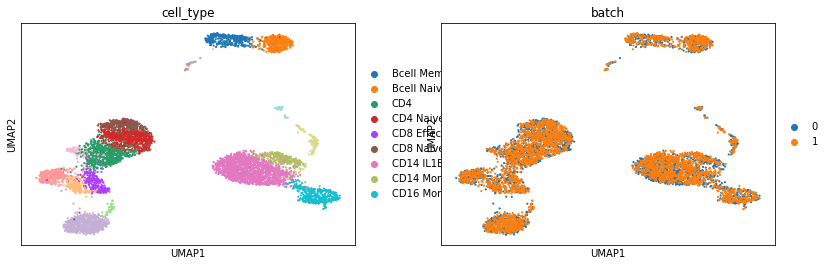

In [301]:
sc.pl.umap(rna, color=['cell_type', 'batch'])

## ATAC-seq

In [302]:
sc.pp.neighbors(scatac1)
sc.tl.umap(scatac1)

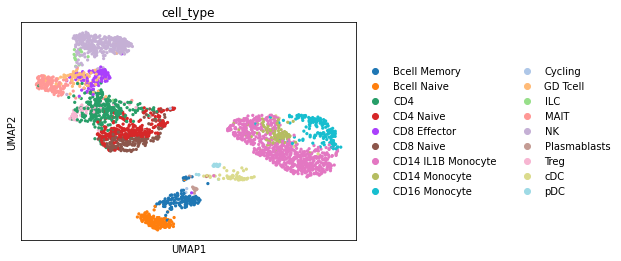

In [303]:
sc.pl.umap(scatac1, color='cell_type')

In [304]:
sc.pp.neighbors(scatac2)
sc.tl.umap(scatac2)

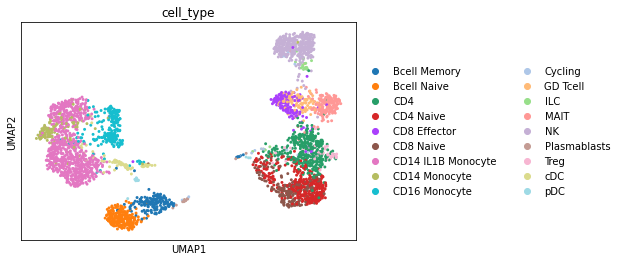

In [305]:
sc.pl.umap(scatac2, color='cell_type')